In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr
from qiskit_metal.analyses.sweep_options.sweeping import Sweeping

### Design

In [3]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

# Perform the necessary imports.
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Add 1 transmons to the design.
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width='425 um',
    pocket_height='650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(a=dict(loc_W=+1, loc_H=+1),
                         b=dict(loc_W=-1, loc_H=+1, pad_height='30um'),
                         c=dict(loc_W=+1, loc_H=-1, pad_width='200um'),
                         d=dict(loc_W=-1, loc_H=-1, pad_height='50um')))

## Create 2 transmons
q1 = TransmonPocket(design,
                    'Q1',
                    options=dict(pos_x='0mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))
#q2 = TransmonPocket(design,
#                    'Q2',
#                    options=dict(pos_x='-0.6mm',
#                                 pos_y='0mm',
#                                 orientation='90',
#                                 **options))

gui.rebuild()
gui.autoscale()

In [34]:
# Add 1 hangers consisting of capacitively coupled transmission lines.
TQ1 = CoupledLineTee(design,
                     'TQ1',
                     options=dict(pos_x='-0.4mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))
#TQ2 = CoupledLineTee(design,
#                     'TQ2',
#                     options=dict(pos_x='-1mm',
#                                  pos_y='3mm',
#                                  coupling_length='500um',
#                                  coupling_space='1um'))

gui.rebuild()
gui.autoscale()

In [6]:
# Add 2 meandered CPWs connecting the transmons to the hangers.
ops = dict(fillet='90um')
design.overwrite_enabled = True

options1 = Dict(total_length='8mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                               pin='second_end'),
                                end_pin=Dict(component='Q1', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

#options2 = Dict(total_length='9mm',
#                hfss_wire_bonds=True,
#                pin_inputs=Dict(start_pin=Dict(component='TQ2',
#                                               pin='second_end'),
#                                end_pin=Dict(component='Q2', pin='a')),
#                lead=Dict(start_straight='0.1mm'),
#                **ops)

meanderQ1 = RouteMeander(design, 'meanderQ1', options=options1)
#meanderQ2 = RouteMeander(design, 'meanderQ2', options=options2)

gui.rebuild()
gui.autoscale()

In [37]:
# Add 2 open to grounds at the ends of the horizontal CPW.
otg1 = OpenToGround(design, 'otg1', options=dict(pos_x='1mm', pos_y='3mm'))
otg2 = OpenToGround(design,
                    'otg2',
                    options=dict(pos_x='-1.4mm', pos_y='3mm', orientation='180'))

gui.rebuild()
gui.autoscale()

# Add 3 straight CPWs that comprise the long horizontal CPW.

ops_oR = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ1', pin='prime_end'),
                              end_pin=Dict(component='otg1', pin='open')))
#ops_mid = Dict(hfss_wire_bonds=True,
#               pin_inputs=Dict(start_pin=Dict(component='TQ1',
#                                              pin='prime_start'),
#                               end_pin=Dict(component='TQ2', pin='prime_end')))
ops_oL = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                             pin='prime_start'),
                              end_pin=Dict(component='otg2', pin='open')))

cpw_openRight = RouteStraight(design, 'cpw_openRight', options=ops_oR)
#cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)
cpw_openLeft = RouteStraight(design, 'cpw_openLeft', options=ops_oL)

gui.rebuild()
gui.autoscale()

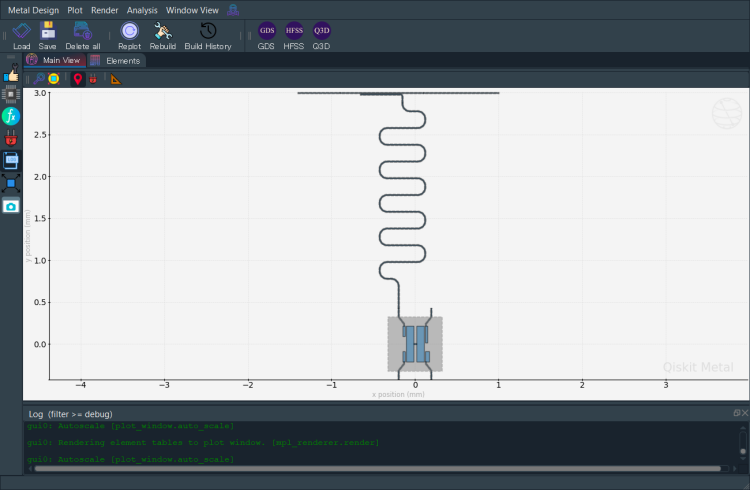

In [38]:
gui.screenshot()

In [63]:
#Reference to Ansys hfss QRenderer
hfss = design.renderers.hfss

# This cell will open the Ansys application.  Run this cell, if Ansys, is not already open.
# A project will be opened using this command.
hfss.open_ansys(path_var='ANSYSEM_ROOT211')

In [64]:
sweep = Sweeping(design)

In [65]:
# Set the buffer width at the edge of the design to be 0.5 mm
# in both directions.

hfss.options['x_buffer_width_mm'] = 0.5
hfss.options['y_buffer_width_mm'] = 0.5

In [66]:
selection = [] # Means to render everything in qgeometry table.
open_pins = []

# Here, pin cpw_openRight_end and cpw_openLeft_end are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('cpw_openRight', 'end', 50),
                      ('cpw_openLeft', 'end', 50)]
jj_to_port = [('Q1', 'rect_jj', 50, False)]
# Neither of the junctions in Q1 or Q2 are rendered.
ignored_jjs = [('Q2', 'rect_jj')]
box_plus_buffer = True

dm_render_args = Dict(selection=selection,
                      open_pins=open_pins,
                      port_list=port_list,
                      jj_to_port=jj_to_port,
                      ignored_jjs=ignored_jjs,
                      box_plus_buffer=box_plus_buffer)

In [67]:
# Pass a dict with arguments to be used add Setup to project.
# If you don't pass all the arguments, the default is determined by
# QHFSSRenderer's default_options.
# The name of setup will be "Sweep_dm_setup".
# If a setup named "Sweep_dm_setup" exists in the project, it will be deleted,
# and a new setup will be added with the arguments from setup_args.
hfss_dm_setup_args = Dict(freq_ghz=None,
                          max_delta_s=None,
                          max_passes=None,
                          min_passes=None,
                          min_converged=None,
                          pct_refinement=None,
                          basis_order=None)
# Example of updating the keys that we are interested in.
hfss_dm_setup_args = Dict(
    freq_ghz=6.0,
    max_delta_s=0.05,
    max_passes=12,
    min_passes=2,
)


In [68]:
dm_add_sweep_args = Dict(name="Sweep_options__dm_sweep",
                         start_ghz=4.0,
                         stop_ghz=5.0,
                         count=1001,
                         type="Interpolating")


In [69]:
all_sweeps, return_code = sweep.sweep_one_option_get_drivenmodal_solution_data(
    meanderQ1.name,
    'total_length', ['9mm', '8mm', '7mm'],
    dm_render_args,
    setup_args=hfss_dm_setup_args,
    dm_add_sweep_args=dm_add_sweep_args,
    leave_last_design=True)

INFO 02:25AM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:25AM [load_ansys_project]: 	Opened Ansys App
INFO 02:25AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 02:25AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/joshd/Documents/
	Project:   Project9
INFO 02:25AM [connect_design]: No active design found (or error getting active design).
INFO 02:25AM [connect]: 	 Connected to project "Project9". No design detected
02:25AM 27s WARNING [activate_drivenmodal_design]: The name=Sweep_DrivenModal was not in active project.  A new design will be inserted to the project.  Names in active project are: 
[].  
INFO 02:25AM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal [Solution type: DrivenModal]
WARNING 02:25AM [connect_setup]: 	No design setup detected.
WARNING 02:25AM [connect_setup]: 	Creating drivenmodal default setup.
INFO 02:25AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 02:25AM [g

In [51]:
#hfss.disconnect_ansys()

In [70]:
# Each key corresponds to list passed to ['9mm', '8mm', '7mm']
if return_code == 0:
    print(all_sweeps.keys())
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

dict_keys(['9mm', '8mm', '7mm'])


In [71]:
all_sweeps['9mm']['option_name']

'total_length'

In [72]:
# For each key, know if the solution data converged.
if return_code == 0:
    for item in all_sweeps.keys():
        option_name = all_sweeps[item]['option_name']
        did_converge = all_sweeps[item]['convergence']
        print(f'For {option_name}={item}, convergence is {did_converge}.')
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

For total_length=9mm, convergence is True.
For total_length=8mm, convergence is True.
For total_length=7mm, convergence is True.


In [73]:
# For example, just one group of solution data. Look at convergence data.
if return_code == 0:
    print(all_sweeps['9mm']['convergence_t'])
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

             Solved Elements  Max Mag. Delta S
Pass Number                                   
1                       5871               NaN
2                       7634          0.997330
3                       9880          0.322100
4                      12847          0.298420
5                      16705          0.140650
6                      21718          0.086420
7                      28234          0.051565
8                      36706          0.033012
9                      47719          0.020934
10                     62035          0.012599


In [74]:
# Each values use for the given option, has three matrixes:
# scatter, impedance, and admittance.
if return_code == 0:
    print(all_sweeps['9mm'].keys())
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

dict_keys(['option_name', 'convergence', 's_matrix', 'y_matrix', 'z_matrix', 'convergence_t'])


In [75]:
# For example, just one group of solution data.
if return_code == 0:
    print(all_sweeps['9mm']['z_matrix'])
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

                       Z11                  Z21                 Z31  \
4.000 -0.000000-80.542168j  0.000000+92.681598j -0.000000+0.060008j   
4.001 -0.000001-80.517900j  0.000001+92.660508j -0.000000+0.060109j   
4.002 -0.000001-80.493643j  0.000002+92.639429j -0.000000+0.060210j   
4.003 -0.000002-80.469397j  0.000002+92.618362j -0.000000+0.060311j   
4.004 -0.000003-80.445162j  0.000003+92.597305j -0.000000+0.060413j   
...                    ...                  ...                 ...   
4.996  0.000002-60.812971j -0.000002+76.174085j  0.000000-0.087475j   
4.997  0.000001-60.796553j -0.000002+76.160973j  0.000000-0.087277j   
4.998  0.000001-60.780141j -0.000001+76.147868j  0.000000-0.087081j   
4.999  0.000000-60.763734j -0.000001+76.134768j  0.000000-0.086886j   
5.000  0.000000-60.747334j -0.000000+76.121675j -0.000000-0.086692j   

                       Z12                  Z22                 Z32  \
4.000  0.000000+92.681598j -0.00000-080.539530j  0.000000-0.057683j   
4.001

In [85]:
if return_code == 0:
    df_s = all_sweeps['9mm']['s_matrix']
    #print(all_sweeps['9mm']['s_matrix'])
else:
    print('Check warning messages to see why all_sweeps is non-zero.')

In [86]:
df_s['20_log_of_mag_S11']= 20 * np.log10(np.absolute(df_s['S11']))
df_s['20_log_of_mag_S21']= 20 * np.log10(np.absolute(df_s['S21']))
df_s['20_log_of_mag_S31']= 20 * np.log10(np.absolute(df_s['S31']))

# Reference to current axis.
magnitude = plt.figure('Magnitude S11, S21, and S31')
plt.clf()
axis = plt.gca() # Get current axis.
df_s = all_sweeps['9mm']['s_matrix']
#df_s.plot(kind = 'line', y='20_log_of_mag_S11', color = 'green', ax = axis)
df_s.plot(kind = 'line', y='20_log_of_mag_S21', color = 'blue', ax = axis)
#df_s.plot(kind = 'line', y='20_log_of_mag_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Magnitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'|S11|,|S21|,|S31| [dB]')
magnitude.show()

In [87]:
# Data is shown as degrees.
# However, if you want radians, change value of deg to false, deg=False.
df_s['degrees_S11'] = np.angle(df_s['S11'], deg=True)
df_s['degrees_S21'] = np.angle(df_s['S21'], deg=True)
df_s['degrees_S31'] = np.angle(df_s['S31'], deg=True)

# Reference to current axis.
phase = plt.figure('Phase of S11 and S21')
plt.clf()
axis = plt.gca() # Get current axis.
df_s = all_sweeps['9mm']['s_matrix']
df_s.plot(kind = 'line', y='degrees_S11', color = 'green', ax = axis)
df_s.plot(kind = 'line', y='degrees_S21', color = 'blue', ax = axis)
df_s.plot(kind = 'line', y='degrees_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Phase')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'<S11, <S21, <S31 [degrees]')
phase.show()

In [88]:
df_s.head()

,S11,S21,S31,S12,S22,S32,S13,S23,S33,20_log_of_mag_S11,20_log_of_mag_S21,20_log_of_mag_S31,degrees_S11,degrees_S21,degrees_S31
4.000,-0.021220-0.037158j,-0.867415+0.495743j,-0.000024-0.000051j,-0.867415+0.495743j,-0.021245-0.037144j,0.000017+0.000054j,-0.000024-0.000051j,0.000017+0.000054j,0.985055-0.172240j,-27.373116,-0.007959,-84.923737,-119.729689,150.251278,-115.002472
4.001,-0.021230-0.037164j,-0.867350+0.495855j,-0.000024-0.000052j,-0.867350+0.495855j,-0.021254-0.037150j,0.000017+0.000054j,-0.000024-0.000052j,0.000017+0.000054j,0.985047-0.172283j,-27.371131,-0.007963,-84.904943,-119.737136,150.243842,-115.008178
4.002,-0.021239-0.037169j,-0.867285+0.495967j,-0.000024-0.000052j,-0.867285+0.495967j,-0.021264-0.037155j,0.000017+0.000054j,-0.000024-0.000052j,0.000017+0.000054j,0.985040-0.172326j,-27.369147,-0.007967,-84.886123,-119.744582,150.236406,-115.013884
4.003,-0.021249-0.037175j,-0.867220+0.496080j,-0.000024-0.000052j,-0.867220+0.496080j,-0.021274-0.037161j,0.000017+0.000054j,-0.000024-0.000052j,0.000017+0.000054j,0.985033-0.172369j,-27.367164,-0.007970,-84.867276,-119.752029,150.228970,-115.019590
4.004,-0.021259-0.037181j,-0.867156+0.496192j,-0.000024-0.000052j,-0.867156+0.496192j,-0.021283-0.037167j,0.000017+0.000054j,-0.000024-0.000052j,0.000017+0.000054j,0.985025-0.172411j,-27.365181,-0.007974,-84.848403,-119.759476,150.221534,-115.025296


In [89]:
df_s.to_csv("s21_data.csv")

In [26]:
# In HFSS, after the last sweep, should the design be cleared?  The argument "leave_last_design" is true by default.
# If you want to delete after last sweep, change argument to false.

leave_last_design = False

all_sweeps, return_code = sweep.sweep_one_option_get_drivenmodal_solution_data(
    meanderQ1.name,
    'total_length', ['9mm', '8mm', '7mm'],
    dm_render_args,
    setup_args=hfss_dm_setup_args,
    dm_add_sweep_args=dm_add_sweep_args,
    leave_last_design=leave_last_design)

INFO 10:47AM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:47AM [load_ansys_project]: 	Opened Ansys App
INFO 10:47AM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 10:47AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/joshd/Documents/
	Project:   Project8
INFO 10:47AM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal [Solution type: DrivenModal]
INFO 10:47AM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:47AM [connect]: 	Connected to project "Project8" and design "Sweep_DrivenModal" 😀 

INFO 10:47AM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal [Solution type: DrivenModal]
INFO 10:47AM [get_setup]: 	Opened setup `Sweep_dm_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:48AM [get_setup]: 	Opened setup `Sweep_dm_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:48AM [get_setup]: 	Opened setup `Sweep_dm_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 10:48AM [